<div style="padding: -5px;
  text-align: center;
  color: white;
  font-size: 15px;">
   <img src="images/banner.jpg" alt="MINE-Seminario de programación" style="width:100%;">
  <h1 style="
  position: absolute;
  top: 5%;
  left: 50%;">Caso de Estudio</h1>
</div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploración-datos" data-toc-modified-id="Exploración-datos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploración datos</a></span></li><li><span><a href="#Nivel-de-obesidad" data-toc-modified-id="Nivel-de-obesidad-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Nivel de obesidad</a></span></li><li><span><a href="#Exploración-Previa---Solo-cuantitativa" data-toc-modified-id="Exploración-Previa---Solo-cuantitativa-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploración Previa - Solo cuantitativa</a></span></li><li><span><a href="#Exploración-Total" data-toc-modified-id="Exploración-Total-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploración Total</a></span></li><li><span><a href="#Aprendizaje-Supervisado" data-toc-modified-id="Aprendizaje-Supervisado-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Aprendizaje Supervisado</a></span></li><li><span><a href="#Infome-Final" data-toc-modified-id="Infome-Final-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Infome Final</a></span></li></ul></div>

#  Nivel de obesidad

En el siguiente enlace encontrarán una base de datos que permiten estimarlos niveles de obesidad en individuos de los países de México, Perú y Colombia, con base en sus hábitos alimenticios y condición física. Los datos contienen 17 atributos y 2111 registros, además, hay una variable `NObesidad` (Nivel de obesidad), que permite clasificar los datos utilizando los valores de Peso Insuficiente, Peso Normal, Nivel de Sobrepeso I, Nivel de Sobrepeso II, Obesidad Tipo I , Obesidad tipo II y Obesidad tipo III. El 77% de los datos se generaron sintéticamente utilizando la herramienta Weka y el filtro SMOTE, el 23% de los datos se recopilaron directamente de los usuarios a través de una plataforma web, la información acerca de los datos y los paper relevantes que se han creado a partir de este ejercicio lo pueden encontrar en:

[ Estimation of obesity levels based on eating habits and physical condition Data Set ](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+)



Este ejercicio guiado pretende que ustedes hagan una exploración completa a la base, identifiquen grupos en la población y desarrolen modelos que permitan determinar el nivel de obesidad para cualquier individuo.

Después de descargar, cargamos la base:

In [1]:
#Paquetes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [20]:
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier
import pandas_profiling as pdp

In [2]:
Datos=pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

In [46]:
#Funciones útiles
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = [0 if i<0.5 else 1 for i in bin_clas.predict(X, verbose=0)]
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='GnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

Hagan una exploración manual de la base, identifiquen las variables y los tipos de variables a las que nos enfretamos y, con su grupo, plantee unas hipótesis frente a las tareas planteadas. En lo que sigue se sugeriran algunos puntos a desarrollar en este trabajo.

Tipo de datos y resumen:

In [4]:
Datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

Visualización de datos

In [5]:
Datos.head(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


Se redondean todas las variables numericas

In [6]:
Datos[Datos.columns[[1,6,7,10,12,13]]]=Datos[Datos.columns[[1,6,7,10,12,13]]].round()
Datos.sample(15)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
698,Female,17.0,1.777929,44.762023,no,yes,3.0,3.0,Sometimes,no,2.0,no,2.0,2.0,Sometimes,Public_Transportation,Insufficient_Weight
447,Male,19.0,1.800000,87.000000,yes,yes,2.0,4.0,Sometimes,no,2.0,no,2.0,1.0,Sometimes,Public_Transportation,Overweight_Level_I
1047,Male,20.0,1.704141,78.790936,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Sometimes,Public_Transportation,Overweight_Level_II
866,Female,18.0,1.498561,55.376512,no,yes,2.0,3.0,Sometimes,no,1.0,yes,0.0,1.0,Sometimes,Public_Transportation,Overweight_Level_I
1586,Male,26.0,1.772190,114.097656,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_II
2037,Female,26.0,1.609370,105.407313,yes,yes,3.0,3.0,Sometimes,no,3.0,no,0.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III
1092,Male,22.0,1.717722,81.929910,yes,yes,2.0,1.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Overweight_Level_II
943,Male,24.0,1.776347,82.329047,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Overweight_Level_I
42,Female,21.0,1.660000,64.000000,yes,yes,1.0,3.0,Sometimes,no,1.0,no,0.0,0.0,no,Public_Transportation,Normal_Weight
50,Female,21.0,1.610000,54.500000,yes,yes,3.0,3.0,Sometimes,no,3.0,no,0.0,1.0,Sometimes,Walking,Normal_Weight


## Exploración de datos

La idea en esta sección es hacer un EDA sobre la base. Es muy importante identificar datos atípicos, nulos y relaciones entre variables (colinealidad, alta correlación, etc.).

In [7]:
Datos.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.315964,1.701677,86.586058,2.423496,2.687826,2.014685,1.006632,0.664614
std,6.357078,0.093305,26.191172,0.583905,0.809680,0.688616,0.895462,0.674009
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.630000,65.473343,2.000000,3.000000,2.000000,0.000000,0.000000
50%,23.000000,1.700499,83.000000,2.000000,3.000000,2.000000,1.000000,1.000000
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.000000,2.000000,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [ ]:
pdp.ProfileReport(Datos)

<AxesSubplot:>

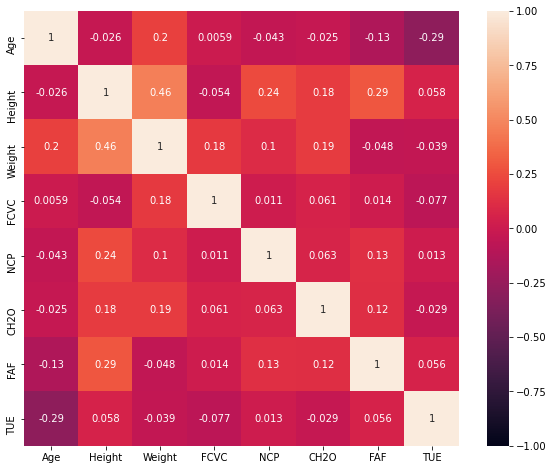

In [8]:
plt.figure(figsize=(10, 8))

sns.heatmap(Datos.corr(), annot=True, square=True, vmin=-1, vmax=1)

In [9]:
Datos.corr()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Age,1.000000,-0.026184,0.203452,0.005941,-0.043440,-0.024554,-0.133161,-0.286071
Height,-0.026184,1.000000,0.463136,-0.053772,0.244055,0.180895,0.290594,0.058097
Weight,0.203452,0.463136,1.000000,0.178952,0.103273,0.186316,-0.047948,-0.039376
FCVC,0.005941,-0.053772,0.178952,1.000000,0.011111,0.061140,0.013661,-0.077269
NCP,-0.043440,0.244055,0.103273,0.011111,1.000000,0.063477,0.130322,0.013010
CH2O,-0.024554,0.180895,0.186316,0.061140,0.063477,1.000000,0.118205,-0.029207
FAF,-0.133161,0.290594,-0.047948,0.013661,0.130322,0.118205,1.000000,0.055513
TUE,-0.286071,0.058097,-0.039376,-0.077269,0.013010,-0.029207,0.055513,1.000000


Existe una correlacion positiva baja entre Height y Weight con 0.46, para las demas variables se puede decir que no exite una correlación.

## Nivel de obesidad

Es claro que la altura y el peso son determinantes en el Nivel de obesidad, como lo muestra el siguiente gráfico:

<AxesSubplot:xlabel='Weight', ylabel='Height'>

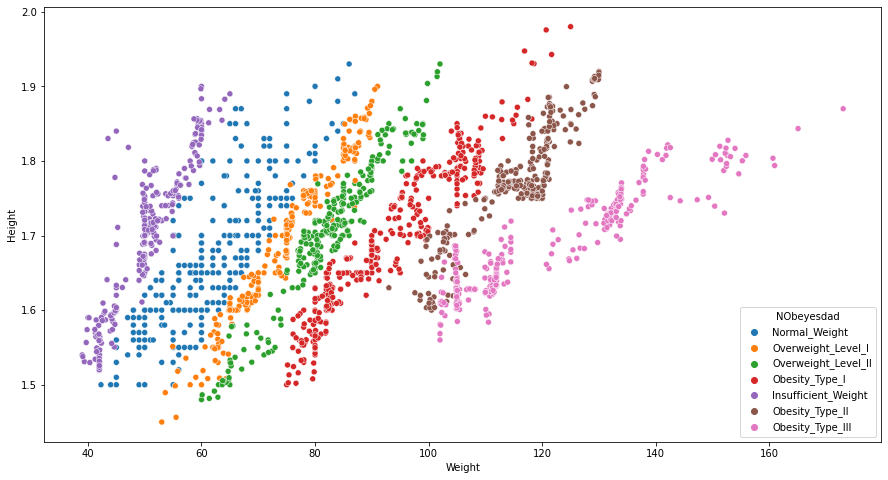

In [10]:
plt.figure(figsize = (15,8))
sns.scatterplot(data=Datos,x='Weight',y='Height',hue='NObeyesdad')

Extraiga esas columnas de la base y haga los análisis a continuación sin tener en cuenta esas variables. Responda:

**¿Tiene sentido haber extraido esas variables? ¿Cómo afectará a mi investigación no tenerlas en cuenta?**

Al momento de generar la red neuronal, tiene un mejor comportamiento cuando el modelo no tiene en cuenta las variables de Height y Weight, por lo que estas variables tienen una correlacion.

In [11]:
Datos1=Datos.drop(Datos.columns[[2, 3]],1)
Datos1

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,21.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,22.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,23.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.0,yes,yes,3.0,3.0,Sometimes,no,3.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III


In [ ]:
pdp.ProfileReport(Datos1)

<AxesSubplot:>

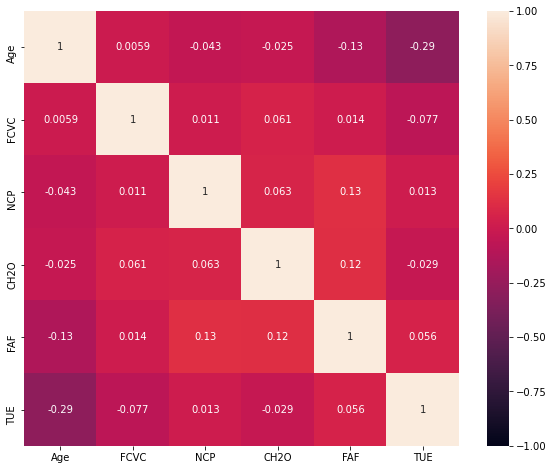

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(Datos1.corr(), annot=True, square=True, vmin=-1, vmax=1)

In [13]:
Datos1.corr()

,Age,FCVC,NCP,CH2O,FAF,TUE
Age,1.000000,0.005941,-0.043440,-0.024554,-0.133161,-0.286071
FCVC,0.005941,1.000000,0.011111,0.061140,0.013661,-0.077269
NCP,-0.043440,0.011111,1.000000,0.063477,0.130322,0.013010
CH2O,-0.024554,0.061140,0.063477,1.000000,0.118205,-0.029207
FAF,-0.133161,0.013661,0.130322,0.118205,1.000000,0.055513
TUE,-0.286071,-0.077269,0.013010,-0.029207,0.055513,1.000000


Ya no existen variables que tengan una correlacion entre ellas.

## Exploración Previa - Solo cuantitativa

1. Tomen las variables cuantitativas y determinen agrupamientos en la base de datos. No olviden fijar una semilla para la revisión del trabajo. No duden en usar métodos que permitan determinar un valor adecuado de agrupamientos.

In [14]:
Datos.groupby('Gender').mean()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Gender,,,,,,,,
Female,24.002876,1.643298,82.302364,2.578140,2.628955,1.961649,0.832215,0.664430
Male,24.621723,1.758690,90.769478,2.272472,2.745318,2.066479,1.176966,0.664794


2. Es importante generar visualizaciones adecuadas de los datos luego tendrán que poner cada registro en un plano cartesiano. Usen reducciones de dimensionalidad.

3. Concluyan a partir de los resultados.

## Aprendizaje Supervisado

En esta sección crearemos modelos que permitan responder la pregunta inicial:

In [15]:
categorical_features = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS','NObeyesdad']
df_cat = pd.get_dummies(Datos[categorical_features])
Datos = Datos.drop(categorical_features, axis=1)
Datos = pd.concat([Datos, df_cat], axis=1)
Datos.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad_Insufficient_Weight,NObeyesdad_Normal_Weight,NObeyesdad_Obesity_Type_I,NObeyesdad_Obesity_Type_II,NObeyesdad_Obesity_Type_III,NObeyesdad_Overweight_Level_I,NObeyesdad_Overweight_Level_II
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,1,0,...,0,1,0,0,1,0,0,0,0,0
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,1,0,...,0,1,0,0,1,0,0,0,0,0
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,0,1,...,0,1,0,0,1,0,0,0,0,0
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,0,1,...,0,1,0,0,0,0,0,0,0,1


In [16]:
categorical_features = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS','NObeyesdad']
df_cat1 = pd.get_dummies(Datos1[categorical_features])
Datos1 = Datos1.drop(categorical_features, axis=1)
Datos1 = pd.concat([Datos1, df_cat1], axis=1)
Datos1.head()

,Age,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,...,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad_Insufficient_Weight,NObeyesdad_Normal_Weight,NObeyesdad_Obesity_Type_I,NObeyesdad_Obesity_Type_II,NObeyesdad_Obesity_Type_III,NObeyesdad_Overweight_Level_I,NObeyesdad_Overweight_Level_II
0,21.0,2.0,3.0,2.0,0.0,1.0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,0
1,21.0,3.0,3.0,3.0,3.0,0.0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,0
2,23.0,2.0,3.0,2.0,2.0,1.0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
3,27.0,3.0,3.0,2.0,2.0,0.0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
4,22.0,2.0,1.0,2.0,0.0,0.0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1


In [17]:
Datos.info(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 2111 non-null   float64
 1   Height                              2111 non-null   float64
 2   Weight                              2111 non-null   float64
 3   FCVC                                2111 non-null   float64
 4   NCP                                 2111 non-null   float64
 5   CH2O                                2111 non-null   float64
 6   FAF                                 2111 non-null   float64
 7   TUE                                 2111 non-null   float64
 8   Gender_Female                       2111 non-null   uint8  
 9   Gender_Male                         2111 non-null   uint8  
 10  family_history_with_overweight_no   2111 non-null   uint8  
 11  family_history_with_overweight_yes  2111 no

1. Particionan la base en 2 (Entrenamiento y testeo) (80/20) de nuevo con semilla fija.

Establecemos la semilla

In [18]:
np.random.seed(2022)

##### Se prepara la base de entrenamiento y la base de testeo para el dataframe con las columnas de peso y tamaño

In [21]:
X = Datos.drop('TUE', axis=1).values
y = Datos['TUE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1688, 37) (1688,) (423, 37) (423,)


In [ ]:
type(X_train)

##### Se prepara la base de entrenamiento y la base de testeo para el dataframe sin las columnas de peso y tamaño

In [22]:
X1 = Datos1.drop('TUE', axis=1).values
y1 = Datos1['TUE'].values
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)
print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)

(1688, 35) (1688,) (423, 35) (423,)


2. Usando la base de entrenamiento crearán algunos modelos de clasificación con los siguientes métodos:

* Regresión Logística
* Arboles de decisión
* Red neuronal

## Red neuronal

##### Base 1

In [25]:
bin_clas = Sequential()
bin_clas.add(Dense(20, input_shape=(X_train.shape[1],), activation='tanh'))
bin_clas.add(Dense(10, activation='tanh'))
bin_clas.add(Dense(1, activation='sigmoid'))

bin_clas.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

bin_hist = bin_clas.fit(X_train, y_train, epochs=100)

Epoch 1/100
53/53 [==============================] - 1s 2ms/step - loss: 0.6340 - accuracy: 0.4301
Epoch 2/100
53/53 [==============================] - 0s 1ms/step - loss: 0.5838 - accuracy: 0.4941
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 0.5558 - accuracy: 0.5231
Epoch 4/100
53/53 [==============================] - 0s 1ms/step - loss: 0.5231 - accuracy: 0.5255
Epoch 5/100
53/53 [==============================] - 0s 1ms/step - loss: 0.5478 - accuracy: 0.5261
Epoch 6/100
53/53 [==============================] - 0s 1ms/step - loss: 0.5115 - accuracy: 0.5598
Epoch 7/100
53/53 [==============================] - 0s 1ms/step - loss: 0.4942 - accuracy: 0.5693
Epoch 8/100
53/53 [==============================] - 0s 1ms/step - loss: 0.5083 - accuracy: 0.5557
Epoch 9/100
53/53 [==============================] - 0s 1ms/step - loss: 0.4931 - accuracy: 0.5806
Epoch 10/100
53/53 [==============================] - 0s 1ms/step - loss: 0.5339 - accuracy: 0.5036
Epoch 11/

<Figure size 576x432 with 0 Axes>

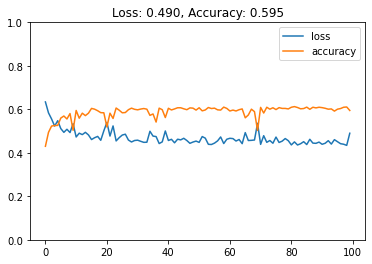

In [26]:
plot_loss_accuracy(bin_hist)

##### Base 2

In [27]:
bin_clas = Sequential()
bin_clas.add(Dense(20, input_shape=(X_train1.shape[1],), activation='tanh'))
bin_clas.add(Dense(10, activation='tanh'))
bin_clas.add(Dense(1, activation='sigmoid'))

bin_clas.compile(Adam(lr=0.005), 'binary_crossentropy', metrics=['accuracy'])

bin_hist = bin_clas.fit(X_train1, y_train1, epochs=100)

Epoch 1/100
53/53 [==============================] - 1s 1ms/step - loss: 0.6396 - accuracy: 0.4402
Epoch 2/100
53/53 [==============================] - 0s 1ms/step - loss: 0.5454 - accuracy: 0.5148
Epoch 3/100
53/53 [==============================] - 0s 1ms/step - loss: 0.5218 - accuracy: 0.5350
Epoch 4/100
53/53 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.5586
Epoch 5/100
53/53 [==============================] - 0s 1ms/step - loss: 0.4826 - accuracy: 0.5598
Epoch 6/100
53/53 [==============================] - 0s 1ms/step - loss: 0.4617 - accuracy: 0.5699
Epoch 7/100
53/53 [==============================] - 0s 1ms/step - loss: 0.4377 - accuracy: 0.5829
Epoch 8/100
53/53 [==============================] - 0s 1ms/step - loss: 0.4282 - accuracy: 0.5776
Epoch 9/100
53/53 [==============================] - 0s 1ms/step - loss: 0.4278 - accuracy: 0.5741
Epoch 10/100
53/53 [==============================] - 0s 1ms/step - loss: 0.3842 - accuracy: 0.5918
Epoch 11/

<Figure size 576x432 with 0 Axes>

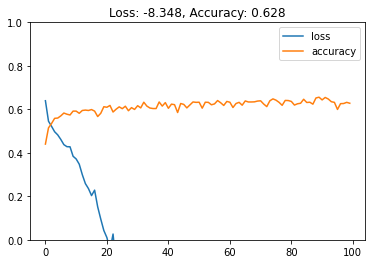

In [28]:
plot_loss_accuracy(bin_hist)

## Regresion Lineal

<Figure size 576x432 with 0 Axes>

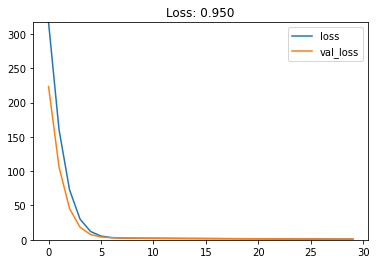

In [29]:
linr_model = Sequential()
linr_model.add(Dense(2, input_shape=(X.shape[1],)))

linr_model.compile('adam', 'mean_squared_error')

linr_history = linr_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2)
plot_loss(linr_history)

<Figure size 576x432 with 0 Axes>

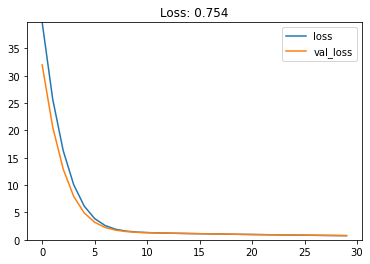

In [30]:
linr_model = Sequential()
linr_model.add(Dense(2, input_shape=(X1.shape[1],)))

linr_model.compile('adam', 'mean_squared_error')

linr_history = linr_model.fit(X_train1, y_train1, epochs=30, verbose=0, validation_split=0.2)
plot_loss(linr_history)

## Regresion logistica

In [33]:
from sklearn import linear_model
model = linear_model.LogisticRegression()
model.fit(X,y)

LogisticRegression()

In [39]:
predictions = model.predict(X)
model.score(X,y)


0.5978209379441023

In [40]:
model1 = linear_model.LogisticRegression()
model1.fit(X1,y1)

LogisticRegression()

In [43]:
predictions1 = model1.predict(X1)
model1.score(X1,y1)


0.5907153008053055